# Lab on Stochastic Linear Bandits :

We provide the environment to run a standard linear bandit experiment. The objective of this lab session is to understand how to implement LinUCB, the algorithm seen in class and its variant LinTS. We shall see that in practice there are some shortcomings in the implementation to make it efficient so we will guide you to obtain a working version.

In [75]:

import numpy as np
from scipy.stats import bernoulli
from math import log

import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import trange

import seaborn as sns
colors = sns.color_palette('colorblind')

In [50]:
def plot_regret(regrets, logscale=False, lb=None,q=10):
    """
    regrets must be a dict {'agent_id':regret_table}
    """

    reg_plot = plt.figure()
    #compute useful stats
#     regret_stats = {}
    for i, agent_id in enumerate(regrets.keys()):
        data = regrets[agent_id]
        N, T = data.shape
        cumdata = np.cumsum(data, axis=1) # cumulative regret

        mean_reg = np.mean(cumdata, axis=0)
        q_reg = np.percentile(cumdata, q, axis=0)
        Q_reg = np.percentile(cumdata, 100-q, axis=0)

#         regret_stats[agent_id] = np.array(mean_reg, q_reg, Q_reg)

        plt.plot(np.arange(T), mean_reg, color=colors[i], label=agent_id)
        plt.fill_between(np.arange(T), q_reg, Q_reg, color=colors[i], alpha=0.2)

    if logscale:
        plt.xscale('log')
        plt.xlim(left=100)

    if lb is not None:
        plt.plot(np.arange(T), lb, color='black', marker='*', markevery=int(T/10))

    plt.xlabel('time steps')
    plt.ylabel('Cumulative Regret')
    plt.legend()
    reg_plot.show()

# Environment Class

The environment class allows to create 3 types of linear bandit problems:
* 'fixed': normally requires a fixed_actions input (otherwise randomly generated at start) which is kept all along the game;
* 'iid': at each round, the environment samples K actions at random on the sphere.

For each of these types of game, the class is used to generate the action sets at each round and the reward for a chosen action (chosen by an Agent, see the "Play!" section for the details of the interaction).

### Action generators
The Action Generator is a function that generates $K$ independent actions in dimension $d$ on the unit sphere. To implement this method, we sampled $K$ times from the isotropic multivariate normal distribution (for independence) and then normalized to have samples in the unit sphere.

In [51]:
def ActionsGenerator(K,d, mean=None):
    """
    K: int -- number of action vectors to be generated
    d : int -- dimension of the action space
    returns : an array of K vectors uniformly sampled on the unit sphere in R^d
    """
    if mean is None:
        mean = np.zeros(d)
    actions = np.random.multivariate_normal(mean, np.eye(d), K)
    actions /= np.linalg.norm(actions, axis=1)[:,np.newaxis]
    return actions


### Linear Bandit environment

The following class is your environment: it generates an action set of K vectors at each round and returns the (random) reward given an action.
You can see how it is used in the experiment function further below.

In [52]:
class LinearBandit:

    def __init__(self, theta, K, var=1., fixed_actions=None):
      """
      theta: d-dimensional vector (bounded) representing the hidden parameter
      K: number of actions per round (random action vectors generated each time)
      pb_type: string in 'fixed', 'iid', 'nsr' (please ignore NotSoRandom)
      """
      self.d = np.size(theta)
      self.theta = theta
      self.K = K
      self.var = var
      self.current_action_set = np.zeros(self.d)

    def get_action_set(self):
      """
      Generates a set of vectors in dimension self.d. Use your ActionsGenerator
      Alternatively, the set of actions is fixed a priori (given as input).
      Implement a condition to return the fixed set when one is given
      """
      self.current_action_set = ActionsGenerator(self.K, self.d)
      return self.current_action_set


    def get_reward(self, action):
      """ sample reward given action and the model of this bandit environment
      action: d-dimensional vector (action chosen by the learner)
      """
      mean = np.dot(action, self.theta)
      return np.random.normal(mean, scale=self.var)

    def get_means(self):
      return np.dot(self.current_action_set, self.theta)




# Play !
The function play runs one path of regret for one agent. The function experiment runs all agents several (Nmc) times and returns all the logged data. Feel free to check the inputs and outputs required when you decide on the implementation of your own agents.

In [ ]:
def play(environment, agent, Nmc, T, pseudo_regret=True):
    """
    Play one Nmc trajectories over a horizon T for the specified agent.
    Return the agent's name (sring) and the collected data in an nd-array.
    """
    data = np.zeros((Nmc, T))
    for n in range(Nmc):
        agent.reset()
        for t in range(T):
            action_set = environment.get_action_set()
            action = agent.get_action(action_set)
            reward = environment.get_reward(action)
            agent.receive_reward(action,reward)

            # compute instant (pseudo) regret
            means = environment.get_means()
            best_reward = np.max(means)
            if pseudo_regret:
              # pseudo-regret removes some of the noise and corresponds to the metric studied in class
              data[n,t] = best_reward - np.dot(environment.theta,action)
            else:
              data[n,t]= best_reward - reward # this can be negative due to the noise, but on average it's positive

    return agent.name(), data


def experiment(environment, agents, Nmc, T,pseudo_regret=True):
    """
    Play Nmc trajectories for all agents over a horizon T. Store all the data in a dictionary.
    """

    all_data = {}

    for agent in agents:
        agent_id, regrets = play(environment, agent,Nmc, T,pseudo_regret)

        all_data[agent_id] = regrets

    return all_data

# Linear Bandit Agents

> Ajouter une citation





## LinUCB : Implementing optimism in $R^d$

As seen in class, the actions are now vectors in $R^d$, representing contextual features, and the environment is assumed to generate rewards according to some hidden linear function $f_\theta(a) = a^\top \theta$. The goal of the learner is thus to estimate $\theta$ while keeping a measure of the uncertainty in all the directions of the feature space.

* **Baseline: Implementation of LinEpsilonGreedy** In the next cell, we implemented a LinUniform Agent that returns one of the action vectors of the action set, chosen uniformly at random. Please implement a `LinEpsilonGreedy` agent and test it against `Greedy` ($\epsilon=0$) on the 2 proposed  environments (iid and fixed actions). What do you notice? Is $\epsilon$-Greedy a good baseline to test algorithms?


* **Implementation of LinUCB**: you need to compute UCBs for each arm of the current action set received from the environment, but this time the exploration bonus depends on the history of taken actions and received rewards (see course material).

* **Efficiency of the matrix inversion step**: One key step is to invert the covariance matrix in order to compute the elliptical norm of each available action. Remark however that at round $t+1$, the new covariance matrix is very similar to the previous one at rount $t$... Can you think of a way to optimize this step by simply updating the old one ? Please implement this improvement as an additional option to your `LinUCB` agent so you can compare runtimes from bandit problems in dimension $d=2,8,16,32,64$. Plot the result of the compared runtimes. 

### Uniform random policy

In [54]:
class LinUniform:
  def __init__(self):
    pass

  def get_action(self, arms):
    K, _ = arms.shape
    return arms[np.random.choice(K)]

  def receive_reward(self, chosen_arm, reward):
    pass

  def reset(self):
    pass

  def name(self):
    return 'Unif'



### Lin-$\epsilon$-Greedy policy:

In [55]:
class LinEpsilonGreedy:
  def __init__(self, d,lambda_reg, eps=0.1, other_option=None):
    self.eps = eps 
    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()
    #use other inputs if needed

  def reset(self):
    """
    This function should reset all estimators and counts.
    It is used between independent experiments (see 'Play!' above)
    """
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.linalg.inv(np.eye(self.d) * self.lambda_reg)
    self.b_t = np.zeros(self.d)

  def get_action(self, arms):
    K, _ = arms.shape
    expl = np.random.random()
    if expl < self.eps:
        action = arms[np.random.choice(K)]
    else:
        action = arms[np.argmax(np.dot(arms, self.hat_theta))]
    return action
    

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    self.cov = self.cov + np.outer(chosen_arm, chosen_arm)
    self.invcov = np.linalg.inv(self.cov) # On inverse directement : pb on va inverser à chaque étape (coût en O(d^3))

    self.b_t += reward * chosen_arm
    self.hat_theta = np.inner(self.invcov, self.b_t) 
    self.t += 1

  def name(self):
    return 'LinEGreedy('+str(self.eps)+')'



In [ ]:
from numpy.linalg import pinv

class LinEpsilonGreedyGB:
  def __init__(self, d,lambda_reg, eps=0.1, other_option=None):
    self.eps = eps 
    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()
    #use other inputs if needed

  def reset(self):
    """
    This function should reset all estimators and counts.
    It is used between independent experiments (see 'Play!' above)
    """
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.linalg.inv(np.eye(self.d) * self.lambda_reg)
    self.b_t = np.zeros(self.d)

  def get_action(self, arms):
    K, _ = arms.shape
    if np.random.rand() < self.eps:
      return arms[np.random.choice(K)]
    else:
      return  arms[np.argmax(np.dot(arms, self.hat_theta))] # on renvoie l'action qui maximise le ps avec theta_hat

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    #update inverse covariance matrix
    self.cov += np.outer(chosen_arm, chosen_arm) # update the covariance matrix
    self.invcov = pinv(self.cov) # update the inverse covariance matrix

    #update b_t
    self.b_t += reward * chosen_arm
  
    self.hat_theta = np.inner(self.invcov, self.b_t) # update the least square estimate
    self.t += 1

  def name(self):
    return 'LinEGreedy('+str(self.eps)+')'

### Default setting

C:\Users\roman\AppData\Local\Temp\ipykernel_62768\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


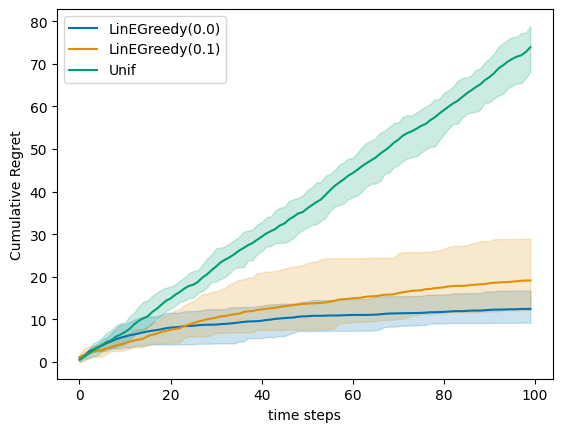

In [57]:
d = 3  # dimension
K = 7  # number of arms

theta = np.array([0.45, 0.5, 0.5])
theta /= np.linalg.norm(theta)

T = 100  
N = 10 

env = LinearBandit(theta, K, var=1)

uniform = LinUniform()
e_greedy = LinEpsilonGreedyGB(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedyGB(d, lambda_reg=1., eps=0.)

exp = experiment(env, [greedy, e_greedy, uniform], Nmc=N, T=T,pseudo_regret=True)
plot_regret(exp)


In [58]:
env = LinearBandit(theta, K, var=1)

uniform = LinUniform()
e_greedy_1 = LinEpsilonGreedy(d, lambda_reg=1., eps=0.8)
e_greedy_2 = LinEpsilonGreedy(d, lambda_reg=1., eps=0.5)
e_greedy_3 = LinEpsilonGreedy(d, lambda_reg=1., eps=0.3)
e_greedy_4 = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)

C:\Users\roman\AppData\Local\Temp\ipykernel_62768\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


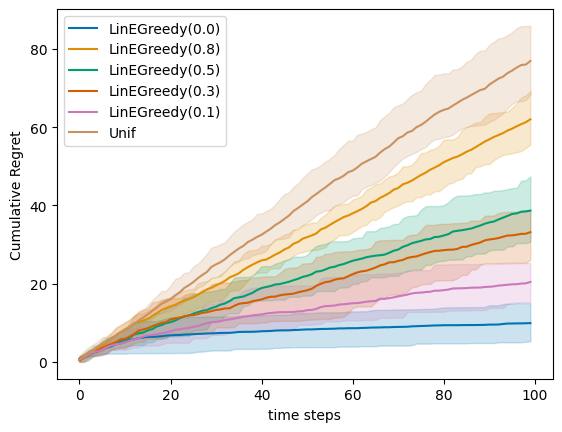

In [59]:
exp = experiment(env, [greedy, e_greedy_1, e_greedy_2, e_greedy_3, e_greedy_4, uniform], Nmc=N, T=T,pseudo_regret=True)
plot_regret(exp)

Is Lin-E-Greedy a strong baseline? Is it hard to beat?

To evaluate the performance of LinEpsGreedy, we create a simple Linear Bandit environment ($K=7$ arms of dimension $d=3$ and a known true vector $\theta$). Then we run LinEpsGreedy and plot the cumulative regret for different values of $\epsilon$ ($\lambda$ = 1, $N_{mc}=10$ Monte Carlo experiments, $T=100$ time steps). We compare LinEpsGreedy with LinUniform and LinGreedy $\epsilon = 0$). 

LinUniform's cumulative regret curve is linear whereas for low values of $\epsilon$, LinEpsGreedy performs better with a logarithmic curve : adding exploitation (i.e. decreasing $\epsilon$) decreases the cumulative regret. Here, we observe that the agent with $\epsilon=0.1$ achieves the best performance, after LinGreedy ($\epsilon = 0)$. This suggests that exploitation might be more effective here. Indeed, we chose a basic low dimension problem where the set of actions is random, explaining why exploitation is very convenient. That is why LinGreedy algorithm outperforms every other choice of $\epsilon$ in this simple case. This would not be true for more complex problems in higher dimension and with fixed actions (where exploration would be required). 

If Linear Epsilon Greedy algorithm can be quite basic and outperformed by more sophisticated algorithms, especially in complex or high-dimensional problems, it remains a reasonable baseline for the Linear Bandit problem. 

The main computational cost in the LinEpsGreedy algorithm is the matrix inversion of $B^\lambda_t$ in the update of $\theta$. The complexity is $O(d^3)$, which is really expensive in high dimension.

To address this issue, we can use an incremental update for $B^\lambda_t$, which avoids inverting a matrix at each step. We used the Sherman-Morisson formula : 

\begin{equation*}
    \begin{aligned}
        (B^{\lambda}_t + x x^\top)^{-1} =( B^{\lambda}_t)^{-1} - \frac{(B^{\lambda}_t)^{-1} x x^\top (B^{\lambda}_t)^{-1}}{1 + x^\top (B^{\lambda}_t)^{-1} x}
    \end{aligned}
\end{equation*}

This update only requires matrix vector multiplications and leads to a complexity of $O(d^2)$.

We ran the following experiment. For different dimensions, we randomly created a Linear Bandit environment with $K = 10$ actions and a vector $\theta$. We ran both LinEpsGreedy with matrix inversion and LinEpsGreedyIncremental with incremental update of $(B^{\lambda}_t)^{-1}$. For different dimensions $d$, we performed the same experiment 10 times with either the original or the incremental algorithm.

In [60]:

class LinEpsilonGreedyIncremental:
  def __init__(self, d,lambda_reg, eps=0.1, other_option=None):
    self.eps = eps 
    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()
    #use other inputs if needed

  def reset(self):
    """
    This function should reset all estimators and counts.
    It is used between independent experiments (see 'Play!' above)
    """
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.linalg.inv(np.eye(self.d) * self.lambda_reg)
    self.b_t = np.zeros(self.d)

  def get_action(self, arms):
    K, _ = arms.shape
    expl = np.random.random()
    if expl < self.eps:
        action = arms[np.random.choice(K)]
    else:
        action = arms[np.argmax(np.dot(arms, self.hat_theta))]
    return action
    

  def receive_reward(self, chosen_arm, reward):
    """
    Update internal quantities to estimate the parameter theta using least squares.
    Uses incremental update for matrix inversion to improve efficiency.
    """
    self.cov = self.cov + np.outer(chosen_arm, chosen_arm)
    self.invcov -= np.outer(self.invcov.dot(chosen_arm), self.invcov.dot(chosen_arm)) / (1. + chosen_arm.dot(self.invcov.dot(chosen_arm)))

    self.b_t += reward * chosen_arm
    self.hat_theta = self.invcov.dot(self.b_t)
    self.t += 1

  def name(self):
    return 'LinEGreedyInc('+str(self.eps)+')'



In [61]:
env = LinearBandit(theta, K, var=1)

e_greedy_1 = LinEpsilonGreedy(d, lambda_reg=1., eps=0.8)
e_greedy_2 = LinEpsilonGreedy(d, lambda_reg=1., eps=0.5)
e_greedy_3 = LinEpsilonGreedy(d, lambda_reg=1., eps=0.3)
e_greedy_4 = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
e_greedy_incr_1 = LinEpsilonGreedyIncremental(d, lambda_reg=1., eps=0.8)
e_greedy_incr_2 = LinEpsilonGreedyIncremental(d, lambda_reg=1., eps=0.5)
e_greedy_incr_3 = LinEpsilonGreedyIncremental(d, lambda_reg=1., eps=0.3)
e_greedy_incr_4 = LinEpsilonGreedyIncremental(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.)
greedy_incr = LinEpsilonGreedyIncremental(d, lambda_reg=1., eps=0.)

C:\Users\roman\AppData\Local\Temp\ipykernel_62768\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


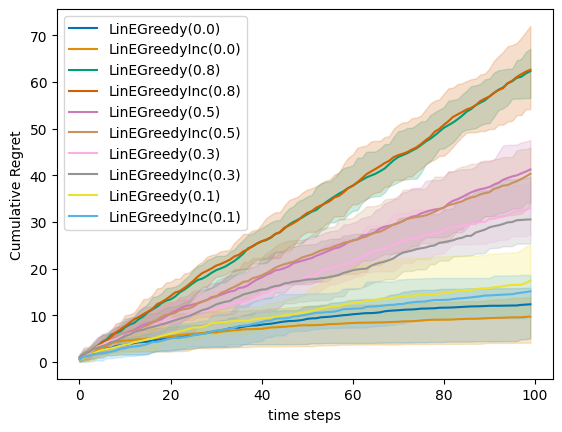

In [62]:
exp = experiment(env, [greedy, greedy_incr, e_greedy_1, e_greedy_incr_1, e_greedy_2, e_greedy_incr_2, e_greedy_3, e_greedy_incr_3, e_greedy_4, e_greedy_incr_4], Nmc=N, T=T,pseudo_regret=True)
plot_regret(exp)

In [ ]:
import time 

def experiment_with_d(d, Nmc=10, T=100):
  """Runs the experiment with a given dimension d and returns the average runtime."""
  theta = np.random.rand(d)
  theta /= np.linalg.norm(theta)
  env = LinearBandit(theta, K, var=1)
  agent1_original = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
  agent1_incremental = LinEpsilonGreedyIncremental(d, lambda_reg=1., eps=0.1)

  start_time_original = time.time()
  results_original = experiment(env, [agent1_original], Nmc=Nmc, T=T, pseudo_regret=True)
  end_time_original = time.time()

  start_time_incremental = time.time()
  results_incremental = experiment(env, [agent1_incremental], Nmc=Nmc, T=T, pseudo_regret=True)
  end_time_incremental = time.time()

  runtime_original = end_time_original - start_time_original
  runtime_incremental = end_time_incremental - start_time_incremental

  return runtime_original, runtime_incremental


# Run the experiment for different dimensions d
dimensions = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100] 
runtime_original_list = []
runtime_incremental_list = []

for d in dimensions:
  runtime_original, runtime_incremental = experiment_with_d(d)
  for n in range(10):
    exp = experiment_with_d(d)
    runtime_original += exp[0]
    runtime_incremental += exp[1]
  runtime_original = runtime_original/10
  runtime_incremental = runtime_incremental/10
  runtime_original_list.append(runtime_original)
  runtime_incremental_list.append(runtime_incremental)


In [17]:
dimensions = [1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100] 

all_relatives_perf=[]
all_relatives_time=[]
for essai in range(10): 
    print('essai', essai)
    times_e_greedy = []
    times_e_greedy_bis = []
    cum_reg_e_greedy=[]
    cum_reg_e_greedy_bis=[]
    for d in dimensions:
        theta = ActionsGenerator(1,d).reshape(d) 
        theta /= np.linalg.norm(theta)

        T = 100  
        N = 10
        sigma = 1.
        q = 10
        env = LinearBandit(theta, K, var=sigma**2)

        e_greedy = LinEpsilonGreedy(d, lambda_reg=1., eps=0.1)
        e_greedy_incr = LinEpsilonGreedyIncremental(d, lambda_reg=1., eps=0.1)
        t1=time.time()
        exp1 = experiment(env, [e_greedy], Nmc=N, T=T,pseudo_regret=True)
        t2=time.time()
        cum_reg_final = np.mean(np.cumsum(exp1['LinEGreedy(0.1)'], axis=1).T[-1])
        cum_reg_e_greedy.append(cum_reg_final)
        times_e_greedy.append(t2-t1)
        t1=time.time()
        exp2 = experiment(env, [e_greedy_incr], Nmc=N, T=T,pseudo_regret=True)
        t2=time.time()
        cum_reg_final = np.mean(np.cumsum(exp2['LinEGreedyInc(0.1)'], axis=1).T[-1])
        cum_reg_e_greedy_bis.append(cum_reg_final)
        times_e_greedy_bis.append(t2-t1)
    perf_relatif = np.array(cum_reg_e_greedy_bis)/np.array(cum_reg_e_greedy)
    time_relatif = np.array(times_e_greedy_bis)/np.array(times_e_greedy)
    all_relatives_perf.append(perf_relatif)
    all_relatives_time.append(time_relatif)
    

essai 0
essai 1
essai 2
essai 3
essai 4
essai 5
essai 6
essai 7
essai 8
essai 9


## Lin-UCB: The optimistic way



In [63]:
class LinUCB: 
  def __init__(self, d, delta=0.1, sigma=1.  ,lambda_reg=1,  other_option=None,):

    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()
    self.delta=delta
    self.sigma=sigma

  def reset(self):
    """
    This function should reset all estimators and counts.
    It is used between independent experiments (see 'Play!' above)
    """
    self.t = 0
    self.hat_theta = np.zeros(self.d)
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.linalg.inv(np.eye(self.d) * self.lambda_reg)
    self.b_t = np.zeros(self.d) 

  
  def get_action(self, arms):
    L = np.max(np.linalg.norm(arms, axis=1))
    R = self.sigma
    S = np.sqrt(self.d)
    beta = np.sqrt(self.lambda_reg) * S + R * np.sqrt(self.d * np.log((1 + self.t * L**2 / self.lambda_reg) / self.delta))

    mu = arms.dot(self.invcov.dot(self.b_t)) + beta * np.sqrt(np.einsum("ij,jk,ik->i", arms, self.invcov, arms))
    return arms[np.argmax(mu)]
  
    #beta = self.sigma * np.sqrt(2*np.log(1/self.delta) + d*np.log(1 + self.t * 1/(self.d*self.lambda_))) + np.sqrt(self.lambda_)*1
    #return  arms[np.argmax([np.dot(arm, self.hat_theta) + np.sqrt(arm.T.dot(self.invcovd.dot(arm))) * beta(self.t, self.delta, self.d, self.lambda_reg, self.sigma) for arm in arms ] )] 

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """
    #update inverse covariance matrix
    x = chosen_arm
    scaled_x = x / self.sigma  
    v = self.invcov.dot(scaled_x) 
    denom = 1 + scaled_x.dot(v)  
    self.invcov -= np.outer(v, v) / denom 

    self.cov += np.outer(scaled_x, scaled_x)

    self.b_t += reward * scaled_x
    self.hat_theta = self.invcov @ self.b_t  # Update theta
    self.t += 1


  def name(self):
    return f'LinUCB(lambda={self.lambda_reg}, delta={self.delta}, sigma = {self.sigma})'
    


### Test against baselines

In [64]:
d = 3  # dimension
K = 7  # number of arms
theta = np.array([0.45, 0.5, 0.5])
theta /= np.linalg.norm(theta)
T = 100
N = 10

env = LinearBandit(theta, K, var=1)

# policies
delta = 0.05
sigma = 1

linucb1 = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
linucb2 = LinUCB(d, delta, sigma=0.1, lambda_reg=1.)
linucb3 = LinUCB(d, delta, sigma=4, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedyGB(d, lambda_reg=1., eps=0.1)
greedy = LinEpsilonGreedyGB(d, lambda_reg=1., eps=0.)


C:\Users\roman\AppData\Local\Temp\ipykernel_62768\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


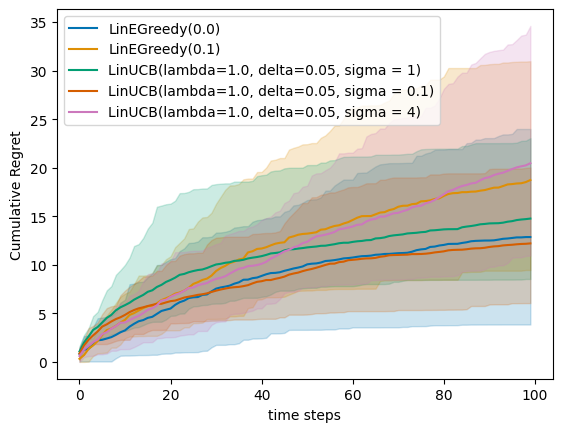

In [65]:
linucb_vs_greedy = experiment(env, [greedy, e_greedy, linucb1, linucb2, linucb3], Nmc=10, T=100,pseudo_regret=True)
plot_regret(linucb_vs_greedy, q=10)

C:\Users\roman\AppData\Local\Temp\ipykernel_62768\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


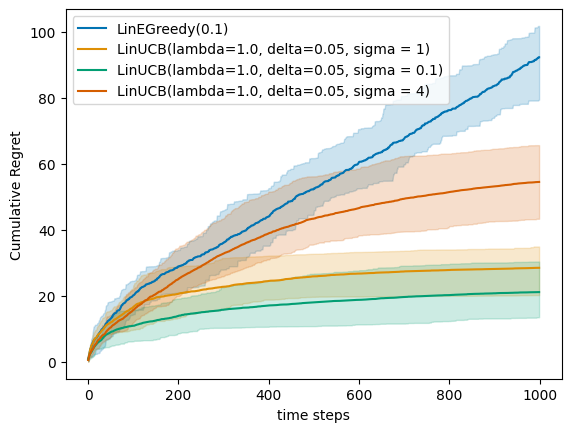

In [66]:
T = 1000
Nmc = 50

linucb_vs_greedy = experiment(env, [e_greedy, linucb1, linucb2, linucb3], Nmc=N, T=T,pseudo_regret=True)
plot_regret(linucb_vs_greedy, q=10)

Despite initially good-looking performance, epsilon-greedy has linear regret and becomes far worse than all other algorithms after t=200 or so. UCB's performance is not too badly affected by the variance input parameter, unless it is way too large (4.0 gives much worse regret).

## LinTS : Taking the Bayesian way

Thompson Sampling is a popular bayesian alternative to the standard optimistic bandit algorithms (see Chapter 36 of Bandit Algorithms). The key idea is to rely on Bayesian *samples* to get a proxy for the hidden parameter $\theta$ of the problem instead of building high-probability confidence regions.

* **Posterior derivation**: Let us place a Gaussian prior with mean $\mathbf{0}$ and covariance $\lambda I$ on $\theta$. Given actions $A_1,\ldots,A_t$ and rewards $Y_1,\ldots,Y_t$, Can you compute the expression of the posterior at the beginning of round $t+1$ ?

In your report, write the distribution of the posterior as a function of the prior and the observed data. No need to report your full derivation if you are lacking space.


* **Implementation of LinTS**. Please implement Linear Thompson Sampling using the formula you derived above.

In [67]:
class LinTS: 
  def __init__(self, d, sigma=1.  ,lambda_reg=1,  other_option=None,):
    self.d = d
    self.lambda_reg = lambda_reg
    self.reset()
    self.sigma=sigma
    self.sum_at_rt=np.zeros(self.d).T

  def reset(self):
    """
    This function should reset all estimators and counts.
    It is used between independent experiments (see 'Play!' above)
    """

    self.t = 0
    self.cov = self.lambda_reg * np.identity(self.d)
    self.invcov = np.identity(self.d)
    self.mu= np.zeros(self.d) 

  def get_action(self, arms):
    theta = np.random.multivariate_normal(self.mu, self.cov)
    theta /= np.linalg.norm(theta)
    return arms[np.argmax(np.dot(arms, theta))]

  def receive_reward(self, chosen_arm, reward):
    """
    update the internal quantities required to estimate the parameter theta using least squares
    """

    self.invcov = self.invcov + (1/self.sigma**2)*np.outer(chosen_arm, chosen_arm) 
    self.cov = pinv(self.invcov)
    self.sum_at_rt+=reward*chosen_arm.T
    self.mu = self.cov @ ((1/sigma**2) * self.sum_at_rt)
    self.t += 1

  def name(self):
    return f'LinTS(lambda={self.lambda_reg}, sigma={self.sigma})'


In [ ]:
d = 3  # dimension
K = 7  # number of arms
theta = np.array([0.45, 0.5, 0.5])
theta /= np.linalg.norm(theta)
T = 100
N = 10

env = LinearBandit(theta, K, var=1)

# policies
delta = 0.05
sigma = 1

linucb1 = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
linucb2 = LinUCB(d, delta, sigma=0.1, lambda_reg=1.)
linucb3 = LinUCB(d, delta, sigma=4, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedyGB(d, lambda_reg=1., eps=0.1)
linTS = LinTS(d, sigma=1., lambda_reg=1.)

C:\Users\roman\AppData\Local\Temp\ipykernel_62768\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


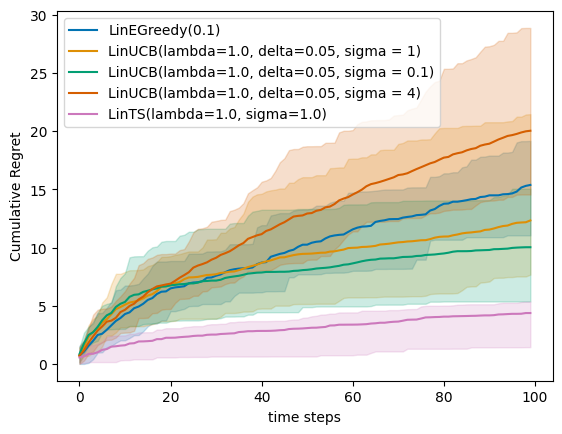

In [72]:
regrets = experiment(env, [e_greedy, linucb1, linucb2, linucb3, linTS], Nmc=N, T=T,pseudo_regret=True)
plot_regret(regrets)

C:\Users\roman\AppData\Local\Temp\ipykernel_62768\3942893175.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  reg_plot.show()


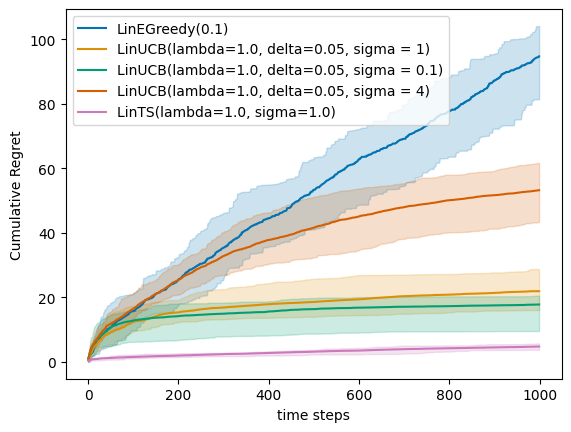

In [74]:
T = 1000
Nmc = 50
regrets = experiment(env, [e_greedy, linucb1, linucb2, linucb3, linTS], Nmc=N, T=T,pseudo_regret=True)
plot_regret(regrets)

In [ ]:
d = 3  # dimension
K = 7  # number of arms
theta = np.array([0.45, 0.5, 0.5])
theta /= np.linalg.norm(theta)
T = 100
N = 10

env = LinearBandit(theta, K, var=1)

# policies
delta = 0.05
sigma = 1

linucb1 = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
linucb2 = LinUCB(d, delta, sigma=0.1, lambda_reg=1.)
linucb3 = LinUCB(d, delta, sigma=4, lambda_reg=1.)
uniform = LinUniform()
e_greedy = LinEpsilonGreedyGB(d, lambda_reg=1., eps=0.1)
linTS = LinTS(d, sigma=1., lambda_reg=1.)

In [85]:
import time 

def experiment_with_d(d, Nmc=10, T=100):
  """Runs the experiment with a given dimension d and returns the average runtime."""
  theta = np.random.rand(d)
  theta /= np.linalg.norm(theta)
  env = LinearBandit(theta, K, var=1)

  agent_LinEps = LinEpsilonGreedyGB(d, lambda_reg=1., eps=0.1)
  agent_UCB = LinUCB(d, delta, sigma=sigma, lambda_reg=1.)
  agent_LinTS = LinTS(d, sigma=1., lambda_reg=1.)

  start_time_Eps = time.time()
  results_Eps = experiment(env, [agent_LinEps], Nmc=Nmc, T=T, pseudo_regret=True)
  end_time_Eps = time.time()

  start_time_UCB = time.time()
  #results_UCB = experiment(env, [agent_UCB], Nmc=Nmc, T=T, pseudo_regret=True)
  end_time_UCB = time.time()

  start_time_TS = time.time()
  #results_TS = experiment(env, [agent_LinTS], Nmc=Nmc, T=T, pseudo_regret=True)
  end_time_TS = time.time()

  runtime_Eps = end_time_Eps - start_time_Eps
  runtime_UCB = end_time_UCB - start_time_UCB
  runtime_TS = end_time_TS - start_time_TS

  return runtime_Eps, runtime_UCB, runtime_TS


# Run the experiment for different dimensions d
dimensions = [1, 5, 10, 20, 30, 40, 60, 80, 100]  # Example dimensions
Runtime_Eps = []
Runtime_UCB = []
Runtime_TS = []

for d in dimensions:
  runtime_Eps, runtime_UCB, runtime_TS = experiment_with_d(d)
  for n in trange(3):
    exp = experiment_with_d(d)
    runtime_Eps += exp[0]
    runtime_UCB += exp[1]
    runtime_TS += exp[2]
  runtime_Eps = runtime_Eps/3
  runtime_UCB = runtime_UCB/3
  runtime_TS = runtime_TS/3
  Runtime_Eps.append(runtime_Eps)
  Runtime_UCB.append(runtime_UCB)
  Runtime_TS.append(runtime_TS)



100%|██████████| 3/3 [00:29<00:00,  9.97s/it]


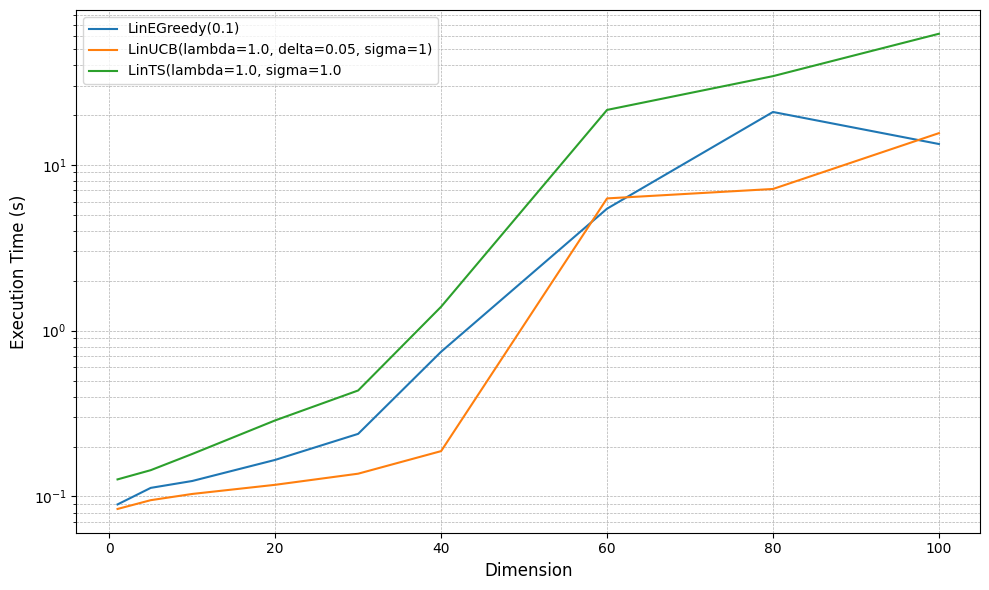

In [ ]:
dimensions = [1, 5, 10, 20, 30, 40, 60, 80, 100]

# Given output of the experiment
Runtime_Eps = [0.08952776590983073, 0.1126549243927002, 0.12395660082499187, 0.16614858309427896, 0.2384662628173828, 0.7456554571787516, 5.433526357014974, 20.800108591715496, 13.332952737808228]
Runtime_UCB = [0.08407195409138997, 0.09497189521789551, 0.10353859265645345, 0.11756833394368489, 0.13719487190246582, 0.1876683235168457, 6.2660497824351, 7.143421649932861, 15.50673246383667]
Runtime_TS = [0.12673354148864746, 0.1440423329671224, 0.1803591251373291, 0.28748583793640137, 0.4354979197184245, 1.392748514811198, 21.405025164286297, 34.208361784617104, 61.61294730504354]

plt.figure(figsize=(10, 6))
plt.plot(dimensions, Runtime_Eps, label="LinEGreedy(0.1)")
plt.plot(dimensions, Runtime_UCB, label="LinUCB(lambda=1.0, delta=0.05, sigma=1)")
plt.plot(dimensions, Runtime_TS, label="LinTS(lambda=1.0, sigma=1.0")
plt.yscale('log')

plt.xlabel("Dimension", fontsize=12)
plt.ylabel("Execution Time (s)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Comparison and report

To compare the three algorithms implemented, we created a Linear Bandit environment with $K=10$ arms in dimension $d=5$, and with Gaussian noise of variance 1. We plot the cumulative regret for the three methods with different parameters ($\epsilon$ for LinEpsGreedy and $\sigma$ the parameter given for the calculation of $\beta(t,\delta)$). 


Although LinEspGreedy ($\epsilon = 0.1$) has the same cumulative regret curve at the beginning of the experiment (low $T$), the regret becomes far worse than all other algorithms as $T$ grows. LinUCB seems to be a better algorithm, working well with $\sigma = 1$, which is the same value as the Gaussian noise. LinUCB with lower $\sigma = 0.1$ has the same performance. Hence the choice of $\sigma$ does not seem to affect the result, except when it is too large. Indeed, LinUCB with $\sigma = 4$ leads to worse regret (curve close to LinEpsGreedy($\epsilon = 0.1$). However, the algorithm that has the best performance in this experiment is LinTS, which regret is clearly lower.

We ran tests with different values of $K$ and $d$ which leads to the same conclusion that LinTS outperforms the other methods when looking at the cumulative regret. The adaptive posterior sampling is well effective in this problem where exploration is needed (as we said, low dimension and random action set). Our final experiment was to compare the mean execution times of LinEpsGreedy, LinUCB and LinTS in a simple problem ($K=10 arms)$, but with varying dimension $d$. We can observe that although LinTS has the best cumulative regret, it is also the algorithm that converges the slower.